# Part 4. Final Model, Mis-classification & Success Predictions Analysis

---

## Importing Libraries

In [67]:
# Importing the usual
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Import joblib
import joblib

# Import NLP library
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Importing classification model
from sklearn.linear_model import LogisticRegression

# Importing Optimzation Tools
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

# Import metrics
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report,\
ConfusionMatrixDisplay

In [68]:
# Set option to display more text
pd.set_option('max_colwidth', 1000)

# Suppress slicing of copy dataframe - as we will make copies
pd.options.mode.chained_assignment = None

---

## Preparation

### Read datasets

In [69]:
# Read csv
post_df = pd.read_csv('../datasets/coursera_edx_posts_cleaned.csv',
                      index_col=[0])

cmt_df = pd.read_csv('../datasets/coursera_edx_comments_cleaned.csv',
                     index_col=[0])

In [71]:
cmt_df

,link_id,subreddit,title,title_length,title_count,title_lemma,title_stem
0,t3_y09o1m,edx,"Financial aid just gives u a discount, you still need to pass the course to get the certificate. Very rarely they change the passing grade, so more people can pass. But financial aid has no influence on this",207,38,financial aid just give u a discount you still need to pas the course to get the certificate very rarely they change the passing grade so more people can pas but financial aid ha no influence on this,financi aid just give u a discount you still need to pass the cours to get the certif veri rare they chang the pass grade so more peopl can pass but financi aid ha no influenc on thi
1,t3_xxluk0,edx,"Not necessarily. Assignments are only for certificate students, and when creating a course it’s possible to restrict individual course pages to certificate students only. Some courses I’ve been involved with have about 10-15% of the material unavailable to auditors.",266,39,not necessarily assignment are only for certificate student and when creating a course it s possible to restrict individual course page to certificate student only some course i ve been involved with have about 10 15 of the material unavailable to auditor,not necessarili assign are onli for certif student and when creat a cours it s possibl to restrict individu cours page to certif student onli some cours i ve been involv with have about 10 15 of the materi unavail to auditor
2,t3_xtm1ea,edx,"You can just access archived courses even if not enrolled, but not purchase anymore or do graded assignments",108,18,you can just access archived course even if not enrolled but not purchase anymore or do graded assignment,you can just access archiv cours even if not enrol but not purchas anymor or do grade assign
3,t3_xsaqli,edx,Cs50 python is more about learning the python language and is probably easier. It has less explanations though and reasoning about computer science. Cs50 teaches you more about theory and would make you a better programmer. You also learn some python in cs50. I’d recommend doing both and cs50 first.,300,50,cs50 python is more about learning the python language and is probably easier it ha le explanation though and reasoning about computer science cs50 teach you more about theory and would make you a better programmer you also learn some python in cs50 i d recommend doing both and cs50 first,cs50 python is more about learn the python languag and is probabl easier it ha less explan though and reason about comput scienc cs50 teach you more about theori and would make you a better programm you also learn some python in cs50 i d recommend do both and cs50 first
4,t3_xseepw,edx,"I’m taking it. I don’t like it but I will complete it. Seems like a mediocre course to push their ibm cloud platform which isn’t very popular in the industry, but might be if you want an ibm job. \n\nAt the same time you will gain some knowledge and understanding of how cloud applications work.\n\nIt does not teach coding in any shape or form. So if you need to learn coding, you must do it elsewhere. You may be able to take the course without much coding knowledge, most things seem to be cut and paste (keep in mind I have experience in most of the languages they used so I might be overstating).\n\nOverall I have been underwhelmed by all ibm edX courses so far.",662,127,i m taking it i don t like it but i will complete it seems like a mediocre course to push their ibm cloud platform which isn t very popular in the industry but might be if you want an ibm job at the same time you will gain some knowledge and understanding of how cloud application work it doe not teach coding in any shape or form so if you need to learn coding you must do it elsewhere you may be able to take the course without much coding knowledge most thing seem to be cut and paste keep in mind i have experience in most of the language they used so i might be overstating overall i have been underwhelmed by all ibm ed

### Stopwords

In [4]:
# Manually adding stopwords
manual_stopwords = stopwords.words('english')

# List of keywords to add
edx_list = ['edx','http','www','org'] 
coursera_list = ['coursera']

# Add to stopwords
manual_stopwords.extend(edx_list)
manual_stopwords.extend(coursera_list)

### Modeling with Title

In [5]:
# Select X and y.values
X = post_df['title_lemma'].values.astype('U')
y = post_df['subreddit']

In [6]:
# Split the data
X_train,X_test,y_train,y_test = train_test_split(X,y,stratify=y,
                                                 random_state=42)

In [7]:
# Check shape
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1495,), (499,), (1495,), (499,))

In [8]:
# Check balance y_train
y_train.value_counts()

coursera    749
edx         746
Name: subreddit, dtype: int64

In [9]:
# Check balance y_test
y_test.value_counts()

coursera    250
edx         249
Name: subreddit, dtype: int64

**The baseline for all our models is 50%, which is the majority class**

### Load Model

In [10]:
lr_gs = joblib.load("../model/lr_model.pkl")

In [11]:
# check parameters
lr_gs.best_params_

{'lr__C': 0.5,
 'lr__n_jobs': -1,
 'tf__max_df': 0.4,
 'tf__max_features': 1000,
 'tf__ngram_range': (1, 1)}

### Borrowing function from model comparison

In [12]:
def fit_pipe(pipe,X_train,X_test,y_train,y_test):
    # Fit model
    pipe.fit(X_train,y_train)

    # Predict model
    y_pred = pipe.predict(X_test)
    
    # Show score
    print(f"Train Score: {pipe.score(X_train,y_train).round(4)}")
    print(f"Test Score: {pipe.score(X_test,y_test).round(4)}")
    
    # Print report
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

In [13]:
def show_cm(pipe,X_train,X_test,y_train,y_test):
    # Fit model
    pipe.fit(X_train,y_train)

    # Predict model
    y_pred = pipe.predict(X_test)
    
    # Generate confusion matrix
    cm = confusion_matrix(y_test,y_pred)
    
    print("Confusion Matrix:")
    ConfusionMatrixDisplay(cm,display_labels=['Coursera','EdX']).plot()
    plt.show();

### Borrowing Functions from EDA

In [14]:
# Create a function to vectorize and return dataframe

def vec_to_df(vec=CountVectorizer(),data=post_df['title']):
    # Vectorize using own choice and return vectorized dataframe
    
    # fit transform title
    d = vec.fit_transform(data)
    
    # Storing into a DataFrame
    df_vec = pd.DataFrame(d.todense(),columns=vec.get_feature_names_out())
    
    return df_vec

In [15]:
# Create a function to plot top recurring words

def plot_top_words(left_df,right_df,
                   top_n=15,title='Top 15 Words'):
    # Plot a comparison of top words mac vs windows
    
    # Generate figures
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,6),sharex=True)
    
    # Plot for Udemy
    left_df.sum().sort_values(ascending=False).head(top_n).\
    plot(kind='barh', ax=ax1, color = '#010000')
    ax1.set_title('EdX')
    
    # Plot for Coursera
    right_df.sum().sort_values(ascending=False).head(top_n).\
    plot(kind='barh', ax=ax2, color = '#0255d1')
    ax2.set_title('Coursera')
    
    # Plot suptitle
    plt.suptitle(title)
    plt.tight_layout()

In [16]:
def compare_words(left_df, right_df, vec_choice='cv', grams=(1,1), top_n=15, feature = 'title',
                  title='Top 15 Words',):
    
    # Select vectorizer and combine vec_to_df and plot_top_words
    
    # Selecting vectorizer choice
    if vec_choice == 'cv':
        vec = CountVectorizer(stop_words=manual_stopwords,
                              ngram_range=grams)
    elif vec_choice == 'tf':
        vec = TfidfVectorizer(stop_words=manual_stopwords,
                              ngram_range=grams)
            
    # Split mac and window then vectorize   
    edx_df  = vec_to_df(vec=vec,data=left_df[feature])
    coursera_df  = vec_to_df(vec=vec,data=right_df[feature])
    
    # Plot to compare
    plot_top_words(left_df = edx_df,
                   right_df = coursera_df,
                   top_n = top_n,
                   title = title)

---

## Logistic Regression

__*Check performance of loaded model*__

In [17]:
# Create Pipeline with loaded GridSearchCV parameters
lr_pipe_best = Pipeline([
    # Step 1. Vectorizer
    ('tf', TfidfVectorizer(max_df=lr_gs.best_params_['tf__max_df'],
                           max_features=lr_gs.best_params_['tf__max_features'],
                           ngram_range=lr_gs.best_params_['tf__ngram_range'],
                           stop_words=manual_stopwords)),
    # Step 2. Estimator
    ('lr', LogisticRegression(C=lr_gs.best_params_['lr__C'],
                              n_jobs=lr_gs.best_params_['lr__n_jobs'],
                              random_state=42))
])

In [18]:
fit_pipe(lr_pipe_best,X_train,X_test,y_train,y_test)

Train Score: 0.8428
Test Score: 0.7114
Classification Report:
              precision    recall  f1-score   support

    coursera       0.73      0.68      0.70       250
         edx       0.70      0.75      0.72       249

    accuracy                           0.71       499
   macro avg       0.71      0.71      0.71       499
weighted avg       0.71      0.71      0.71       499



Confusion Matrix:


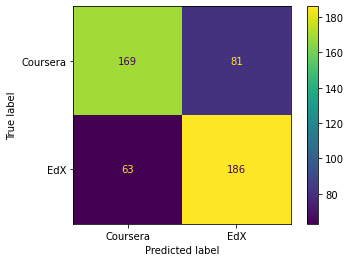

In [19]:
show_cm(lr_pipe_best,X_train,X_test,y_train,y_test)

---

## Investigating misclassification

Investigating misclassification will be done by generating a dataframe of wrong predictions and trained datasets. Which will then be used to evaluate where the model went wrong in those predictions. We will separate our investigation into two groups - *False Positve* and *False Negative*.

**Note:** <br>
- Positive = EdX
- Negative = Coursera

- False postive = predicted EdX but actually Coursera
- False negative = predicted Coursera but actually Edx

### Generating wrong predictions from test set

In [20]:
# Generating wrong predictions dataframe

# Generate predictions
y_pred = lr_gs.predict(X_test)

# Match with results
results = pd.DataFrame({'X_test':X_test,'y_test':y_test,'y_pred':y_pred})

# Generate predict probability
predict_df = pd.DataFrame(lr_gs.predict_proba(X_test),
                          columns=['Coursera','EdX'],index=results.index)

# Generate prediction dataframe
predictions = pd.concat([results,predict_df],axis=1)

# Select only wrong predictions
wrong = pd.DataFrame(predictions[predictions['y_test']!=predictions['y_pred']])

Separating false positives from false negatives

In [21]:
# False positive
false_positive = wrong[(wrong['y_test']=='coursera') & \
                       (wrong['y_pred']=='edx')]
# False negative
false_negative = wrong[(wrong['y_test']=='edx') & \
                       (wrong['y_pred']=='coursera')]

### Generating vectorized train dataset

In [22]:
# Borrowing function from 03_model_comparison notebook

def vec_to_df(vec=CountVectorizer(),data=post_df):
    # Vectorize using own choice and return vectorized dataframe
    
    # fit transform title
    d = vec.fit_transform(data)
    
    # Storing into a DataFrame
    df_vec = pd.DataFrame(d.todense(),columns=vec.get_feature_names_out())
    
    return df_vec

In [23]:
# Store original training data into dataframe and reset index
train = pd.DataFrame({'X_train':X_train,'y_train':y_train})

# Vectorize training data
X_vec_df = vec_to_df(vec=CountVectorizer(stop_words=manual_stopwords),
                     data=X_train).set_index(train.index)

# Concat to train_df
train_df = pd.concat([train,X_vec_df],axis=1)

### Separating Mis-classification

We will create two columns to help us with evaluation. 
<br>
1. how_likely
    - Count how many of each word shows up in training data labeled as `edx` and `coursera`
    - Taking showing up for `edx` labeled as positive and `coursera` as negative
    - Sum up the differences in words showing up in training data for each label
    - Positve means more of the words are labeled `edx`, negative means `coursera`
    
2. how_likely_single
    - Same as *how_likely* but each word will be counted as +1 or -1

In [24]:
def how_likely(string):
    # Function to generate differences in word counts by total counts
    # EdX + 1 / Coursera -1
    diff = 0
    for word in string.split():
        # if words in edx diff + wordcount
        try:
            diff += train_df[train_df['y_train']=='edx'][word].sum()
        except:
            pass
        # if words in coursera diff - wordcount
        try:
            diff -= train_df[train_df['y_train']=='coursera'][word].sum()
        except:
            pass
        
    return diff

In [25]:
def how_likely_single(string):
    # Function to generate differences in word counts by number of words

    # EdX + 1 / Coursera -1
    diff = 0
    
    for word in string.split():
        # Count words
        try:
            edx_count = train_df[train_df['y_train']=='edx'][word].sum()
        except:
            edx_count = 0
        try:
            coursera_count = train_df[train_df['y_train']=='coursera']\
            [word].sum()
        except:
            coursera_count = 0
            
        # compare counts
        if edx_count > coursera_count:
            diff += 1
        elif edx_count < coursera_count:
            diff -= 1
        else:
            pass
        
    return diff

#### Generating `likely_total` and `likely_single` on Training Data

In [26]:
# Generate likely_total and likely_single column
train_df['likely_total'] = train_df['X_train'].apply(how_likely)
train_df['likely_single'] = train_df['X_train'].apply(how_likely_single)

#### False Positive

Generate `likely_total` and `likely_single` column in the `flase_positive` DataFrame

In [27]:
false_positive['likely_total'] = false_positive['X_test'].apply(how_likely)

In [28]:
false_positive['likely_single'] = false_positive['X_test'].apply(how_likely_single)

Investigate relationship between `likely_single` and probability of predicting `edx`

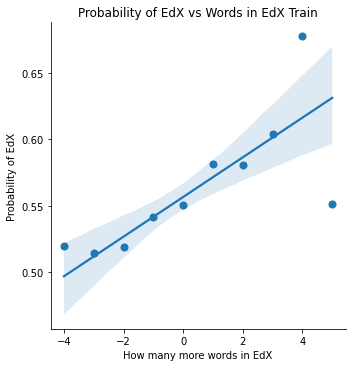

In [29]:
sns.lmplot(y='EdX',x='likely_single',data=false_positive,
           x_estimator=np.mean,x_ci=False)

plt.title('Probability of EdX vs Words in EdX Train')
plt.ylabel('Probability of EdX')
plt.xlabel('How many more words in EdX');

**Key Takeaway:** <br>
- The more words that show up in training data that are labeled `edx`, the more probability the model will predict the title to be from `edx` subreddit
- From this visualization we can breakdown the false positives to three cases:
    1. word count = 0
    2. word count more towards `edx`
    3. word count more towards `coursera`

#### Cause of Error 1. Word Count = 0

In [30]:
# False positive where both likely and likely_1 is more than 0
false_positive[(false_positive['likely_single']==0) & \
               (false_positive['likely_total']==0)]

,X_test,y_test,y_pred,Coursera,EdX,likely_total,likely_single
1805,coursera tesol certif,coursera,edx,0.468972,0.531028,0,0
2060,asking about coursera,coursera,edx,0.435353,0.564647,0,0
1809,who is grading all of this,coursera,edx,0.417551,0.582449,0,0
1983,coursera down,coursera,edx,0.468972,0.531028,0,0
1292,frustrated,coursera,edx,0.468972,0.531028,0,0


#### Case 1. Words didn't show up in training labeled `edx` and `coursera` - due to short title

In [31]:
# filtering both equal 0 
train_df[(train_df['likely_total']==0)&(train_df['likely_single']==0)]\
['y_train'].value_counts()

edx         23
coursera     8
Name: y_train, dtype: int64

**Key Takeaway:** <br>
- For titles with words that show up equally for `edx` and `coursera` on the training dataset
- This happens more often for those that are labeled `edx`
- Meaning for this case, the model will automatically select `edx` as prediction

#### Case 2. Words show up equally in training labeled `edx` and `coursera`

In [32]:
train_df[train_df['test']>0]['y_train'].value_counts()

edx         4
coursera    2
Name: y_train, dtype: int64

In [33]:
train_df[train_df['retake']>0]['y_train'].value_counts()

coursera    2
Name: y_train, dtype: int64

#### Cause of Error 2. Word Count > 0 - topics discussed more in `coursera` subreddit

In [34]:
# False positive where likely_total and likely_single is more than 0
false_positive[(false_positive['likely_single']>0) & \
               (false_positive['likely_total']>0)][:10]

,X_test,y_test,y_pred,Coursera,EdX,likely_total,likely_single
1906,employer tuition assistance,coursera,edx,0.330849,0.669151,6,1
1747,no software experience,coursera,edx,0.377401,0.622599,12,2
2181,information on coursera,coursera,edx,0.375066,0.624934,5,1
1485,proof of enrollment,coursera,edx,0.414248,0.585752,1,1
2083,start date are all false,coursera,edx,0.356525,0.643475,15,1
2236,coursera writing and editing is it worth it,coursera,edx,0.389041,0.610959,5,2
2226,coursera about to become the worst platform,coursera,edx,0.413608,0.586392,3,2
1808,what happened to introduction to astronomy,coursera,edx,0.315232,0.684768,26,2
1259,b sc in computer science by university of london,coursera,edx,0.457411,0.542589,35,2
2058,question,coursera,edx,0.410304,0.589696,9,1


#### Case 1. Titles have topics that are dominated by `edx` subreddit

e.g. hse master of finance - finance courses are more dominated by `edx` as `coursera` are mostly tech related courses, additionally `edx` is partnered with universities and masters degree has been one of the main selling point for them.

In [35]:
train_df[train_df['finance']>0]['y_train'].value_counts()

edx         9
coursera    1
Name: y_train, dtype: int64

In [36]:
train_df[train_df['master']>0]['y_train'].value_counts()

edx         15
coursera    12
Name: y_train, dtype: int64

#### Case 2. Generic words that unformationately show up more in the `edx` subreddit

e.g. where to access live chat

In [37]:
train_df[train_df['access']>0]['y_train'].value_counts()

edx         25
coursera    19
Name: y_train, dtype: int64

In [38]:
train_df[train_df['live']>0]['y_train'].value_counts()

edx         4
coursera    2
Name: y_train, dtype: int64

#### Cause of Error 3. Word Count < 0 - topics discussed more in `coursera` in terms of number of words not necessarily word frequency

In [39]:
# False positive where likely_total and likely_single is more than 0
false_positive[(false_positive['likely_single']<0) & \
               (false_positive['likely_total']<0)][:10]

,X_test,y_test,y_pred,Coursera,EdX,likely_total,likely_single
1729,your grade ha been overridden and adjusted,coursera,edx,0.482831,0.517169,-3,-1
1280,if you sign up to unlimited can you get certificate for the course you e already completed,coursera,edx,0.484102,0.515898,-41,-2
2017,view certificate,coursera,edx,0.498440,0.501560,-19,-2
1265,beware iit roorkee postgraduate certificate on coursera,coursera,edx,0.491844,0.508156,-19,-2
1944,most annoying thing when doing an online course,coursera,edx,0.432695,0.567305,-7,-1
1686,lost all progress and all saved course no way to contact coursea for answer,coursera,edx,0.485972,0.514028,-11,-3
1636,workload of taking two certificate course at the same time,coursera,edx,0.456835,0.543165,-17,-1
1857,will there be a sale during black friday,coursera,edx,0.469710,0.530290,-1,-1
1798,ha corusera helped you gain employment,coursera,edx,0.468972,0.531028,-4,-1
2050,what is mastertrack certificate,coursera,edx,0.491844,0.508156,-19,-2


#### Case 1. Title have words that show up in `Coursera` subreddit but outweight by default prediction of `edx`

e.g. cleaning up r coursera

In [40]:
train_df[train_df['cleaning']>0]['y_train'].value_counts()

coursera    1
Name: y_train, dtype: int64

e.g. public health on cousera

In [41]:
train_df[train_df['public']>0]['y_train'].value_counts()

edx         1
coursera    1
Name: y_train, dtype: int64

In [42]:
train_df[train_df['health']>0]['y_train'].value_counts()

coursera    2
Name: y_train, dtype: int64

#### False Negative

Generate `likely_total` and `likely_single` column in the `flase_positive` DataFrame

In [43]:
false_negative['likely_total'] = false_negative['X_test'].apply(how_likely)

In [44]:
false_negative['likely_single'] = false_negative['X_test']\
.apply(how_likely_single)

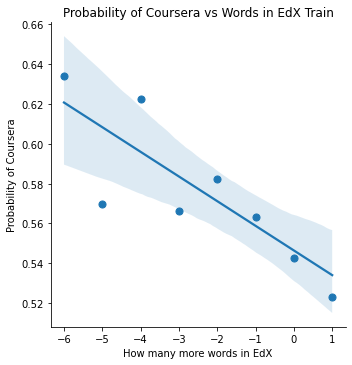

In [45]:
sns.lmplot(y='Coursera',x='likely_single',data=false_negative,
           x_estimator=np.mean,x_ci=False)

plt.title('Probability of Coursera vs Words in EdX Train')
plt.ylabel('Probability of Coursera')
plt.xlabel('How many more words in EdX');

**Key Takeaway:** <br>
- The more words that show up in training data that are labeled `edx`, the less probability the model will predict the title to be from `coursera` subreddit
- From this visualization we can breakdown the false positives to three cases:
    1. word count = 0
    2. word count more towards `edx`
    3. word count more towards `coursera`

### Cause of Error 1. Word Count = 0 for `likely_single`

In [46]:
false_negative[(false_negative['likely_single']==0)]

,X_test,y_test,y_pred,Coursera,EdX,likely_total,likely_single
773,what doe a computer science degree look like,edx,coursera,0.521281,0.478719,26,0
814,problem with cybermonday sale,edx,coursera,0.616802,0.383198,-6,0
147,i am having problem in understanding english lecture a little bit a i am a non native english speaker so whenever i watch a lecture a new word pop up and it break the flow and it take a lot longer to complete the lecture so if this happens to u too how u cope up with it plz tell,edx,coursera,0.507469,0.492531,-3,0
669,account setting update issue edit disabled verification denied,edx,coursera,0.506572,0.493428,-13,0
468,technical issue,edx,coursera,0.599448,0.400552,-10,0
816,looking for a course regarding animal behavior or psychology wa really interested in asux course about dog,edx,coursera,0.505753,0.494247,-19,0


#### Case 1. Title have same amount of words showing up in `edx` and `coursera` labeled training data, but the frequencies are different

e.g. how to finish a course

In [47]:
train_df[train_df['finish']>0]['y_train'].value_counts()

edx         7
coursera    4
Name: y_train, dtype: int64

In [48]:
train_df[train_df['course']>0]['y_train'].value_counts()

coursera    267
edx         246
Name: y_train, dtype: int64

### Cause of Error 2. Tite have more words showing up in `coursera subreddit`

In [49]:
false_negative[(false_negative['likely_single']<0)
               &(false_negative['likely_single']<0)][:10]

,X_test,y_test,y_pred,Coursera,EdX,likely_total,likely_single
970,need help with cs50x,edx,coursera,0.589111,0.410889,-9,-1
419,edx website freezing,edx,coursera,0.615322,0.384678,-5,-2
201,whats your recommended edx course s want to learn something just for fun,edx,coursera,0.538654,0.461346,-16,-1
682,how will this course help,edx,coursera,0.520877,0.479123,-13,-1
77,trying to decide between 2 logic course,edx,coursera,0.502508,0.497492,-13,-1
820,should i continue,edx,coursera,0.506440,0.493560,-1,-1
228,edx certification,edx,coursera,0.649097,0.350903,-16,-1
14,html error,edx,coursera,0.601426,0.398574,-5,-2
375,i don t get it why is this happening,edx,coursera,0.507789,0.492211,-13,-2
647,paying for a course certificate extends the time i have to earn that certificate after completing the course or just the time i have to access that course,edx,coursera,0.540401,0.459599,-58,-5


#### Case 1. Title have words showing up more in `coursera` training set

e.g. edx certification

In [50]:
train_df[train_df['certification']>0]['y_train'].value_counts()

coursera    23
edx          7
Name: y_train, dtype: int64

e.g. problem with cybermonday sale

In [51]:
train_df[train_df['problem']>0]['y_train'].value_counts()

coursera    12
edx          5
Name: y_train, dtype: int64

In [52]:
train_df[train_df['cybermonday']>0]['y_train'].value_counts()

edx    1
Name: y_train, dtype: int64

### Cause of Error 3. Tite have more words showing up in `edx` subreddit but doesn't outweight in frequency

In [53]:
false_negative[(false_negative['likely_single']>0)
               &(false_negative['likely_single']>0)][:10]

,X_test,y_test,y_pred,Coursera,EdX,likely_total,likely_single
949,can t find any course about computer networking on edx,edx,coursera,0.526927,0.473073,-8,1
474,video lag,edx,coursera,0.529196,0.470804,3,1
390,edx aleks window launching small,edx,coursera,0.501895,0.498105,1,1
754,how long do i have after i finish a course to pay for the certification,edx,coursera,0.515887,0.484113,-22,1
831,question is codeacademy style gamification possible in edx,edx,coursera,0.510630,0.489370,8,1
421,aleks issue help someone lol,edx,coursera,0.542686,0.457314,-8,1
709,anyone who graduated from edx with a master s degree,edx,coursera,0.533375,0.466625,2,1


#### Case 1. Word frequency is higher for `coursera` due to topics of dicussion or simply generic terms

e.g. video lag - generic term

In [54]:
train_df[train_df['video']>0]['y_train'].value_counts()

edx         16
coursera    12
Name: y_train, dtype: int64

e.g. thought on edx certificate for blockchin worth it

In [55]:
train_df[train_df['thought']>0]['y_train'].value_counts()

coursera    3
edx         2
Name: y_train, dtype: int64

In [56]:
train_df[train_df['certificate']>0]['y_train'].value_counts()

coursera    104
edx          90
Name: y_train, dtype: int64

In [57]:
train_df[train_df['worth']>0]['y_train'].value_counts()

edx         12
coursera     9
Name: y_train, dtype: int64

## Summary of Mis-classification

All false positives and false negative can be traced back to 3 main root causes: <br>

1. Short titles that never show up on training dataset
2. Title regarding topics dominated by the other subreddit
3. Marginal differences outweighs by default predict probability

Ways to tackle these error could be:
1. Acquire more training dataset that enough words show up in the training dataset
2. Manually add more dominate words to stopwords with the trade off of reducing the overall accuracy
3. Join the title and comment string to add more training data, and reduces short titles

---

## Successful Predictions Analysis

In [58]:
# Select only wrong predictions
right = pd.DataFrame(predictions[predictions['y_test']==predictions['y_pred']])

In [59]:
# True positive
true_positive = right[(right['y_test']=='edx') & \
                       (right['y_pred']=='edx')]
# True negative
true_negative = right[(right['y_test']=='coursera') & \
                       (right['y_pred']=='coursera')]

In [60]:
# Create columns likely_total and likely_single - true positive
true_positive['likely_total'] = true_positive['X_test'].apply(how_likely)
true_positive['likely_single'] = true_positive['X_test'].apply(how_likely_single)

In [61]:
# Create columns likely_total and likely_single - true negative
true_negative['likely_total'] = true_negative['X_test'].apply(how_likely)
true_negative['likely_single'] = true_negative['X_test'].apply(how_likely_single)

### True Positive

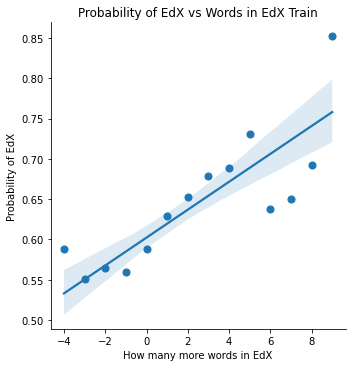

In [62]:
sns.lmplot(y='EdX',x='likely_single',data=true_positive,
           x_estimator=np.mean,x_ci=False)

plt.title('Probability of EdX vs Words in EdX Train')
plt.ylabel('Probability of EdX')
plt.xlabel('How many more words in EdX');

### True Negative

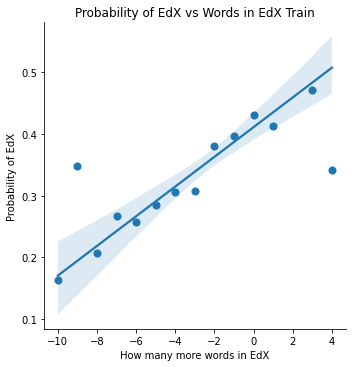

In [63]:
sns.lmplot(y='EdX',x='likely_single',data=true_negative,
           x_estimator=np.mean,x_ci=False)

plt.title('Probability of EdX vs Words in EdX Train')
plt.ylabel('Probability of EdX')
plt.xlabel('How many more words in EdX');

## Visualizing Correct Predicitions

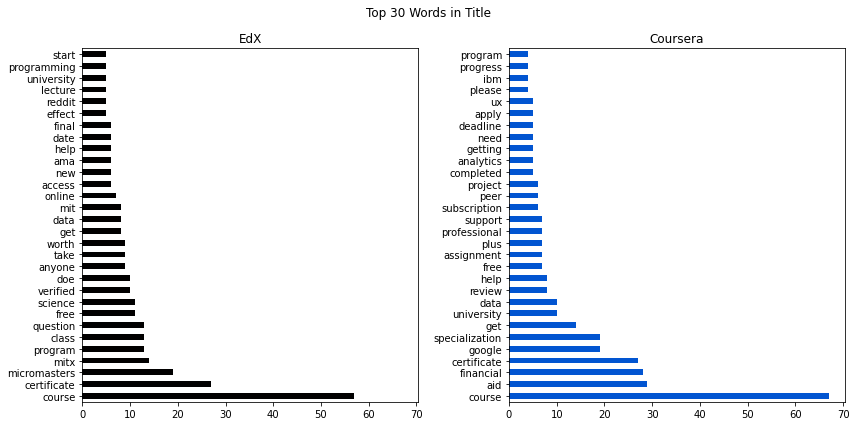

In [64]:
compare_words(left_df=true_positive, right_df = true_negative,
              vec_choice='cv',grams=(1,1),top_n=30, feature = 'X_test',
              title='Top 30 Words in Title')

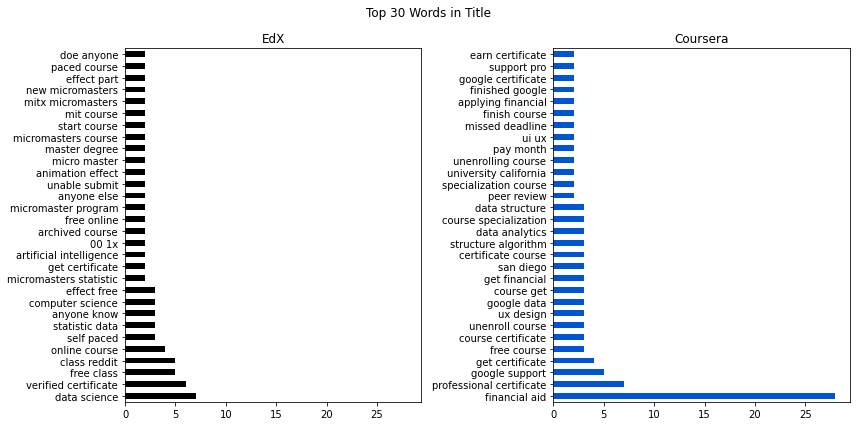

In [65]:
compare_words(left_df=true_positive, right_df = true_negative,
              vec_choice='cv',grams=(2,2),top_n=30, feature = 'X_test',
              title='Top 30 Words in Title')

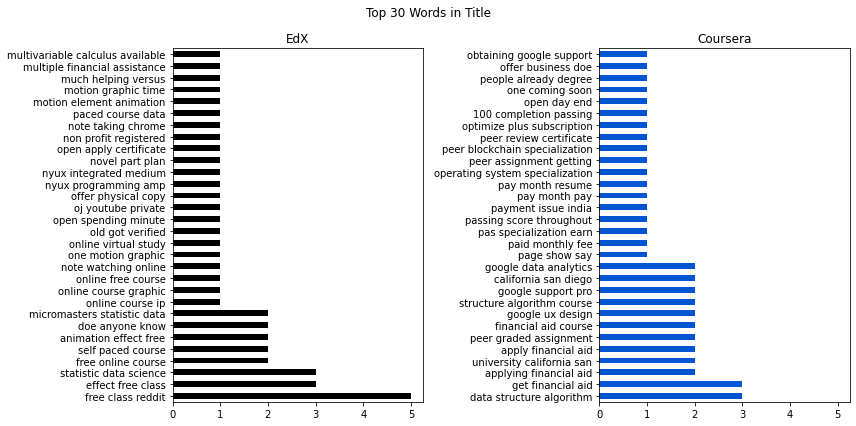

In [66]:
compare_words(left_df=true_positive, right_df = true_negative,
              vec_choice='cv',grams=(3,3),top_n=30, feature = 'X_test',
              title='Top 30 Words in Title')

## Summary of Correct Predicition

All true positives and true negatives can be explained using similar approach to mis-classifications: <br>

1. Title with words and topics that are dominated by each subreddit

Topics that are dominated by each subreddit:
1. *EdX*:
- Courses: Data Science, statistics, and computer science
- Content: Open, online, self-paced, micro-masters
- Deals: Free course

2. *Coursera*:
- Courses: Google Data Analytic, Google UX Design, Machine Learning
- Content: Online courses
- Deals: Financial aids, Sales